**Tasks include building and training simple image autoencoder with 2 layers (essentially PCA), deeper convolutional autoencoder and introducing gaussian noise into pictures to construct denoising autoencoder.**

### Denoising Autoencoders And Where To Find Them

We're going to train deep autoencoders and deploy them to faces and search for similar images.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
torch.cuda.empty_cache()

In [ ]:
!ls './gdrive/MyDrive/celeba/'

### Download data

In [ ]:
#!L
from gfile import download_list

download_list(
    url='https://drive.google.com/file/d/1jGausq7WZM7fF9DbW-Ba0Cn-SWFa7vyS',
    filename='celeba.zip',
    target_dir='./gdrive/MyDrive/celeba/'
)

It took  39.96sec to download 2.5 GB celeba.zip 


In [ ]:
# !L:bash
!unzip './gdrive/MyDrive/celeba/celeba.zip'

In [3]:
#!L
import numpy as np
from matplotlib import pyplot as plt

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.utils import make_grid


EPOCHS = 100
BATCH_SIZE = 32
LEARNING_RATE = 1e-3

LATENT_DIMENSION = 4
BATCH_SIZE = 32

device = torch.device("cuda")

## Prepare dataset

In [4]:
#!L
class CropCelebA64:
    
    def __call__(self, pic):
        new_pic = pic.crop((15, 40, 178 - 15, 218 - 30))
        return new_pic

    def __repr__(self):
        return self.__class__.__name__ + '()'

In [5]:
#!L

# Note that for simplicity we reduce the number of channels to 1
# But if you want to be hardcore feel free to comment .Grayscale :)

train_dataset = torchvision.datasets.CelebA(
    root='celeba',
    split='train',
    transform=torchvision.transforms.Compose([
        CropCelebA64(),
        torchvision.transforms.Resize(64),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        
        torchvision.transforms.Grayscale()
    ]),
)

validation_dataset = torchvision.datasets.CelebA(
    root='celeba',
    split='valid',
    transform=torchvision.transforms.Compose([
        CropCelebA64(),
        torchvision.transforms.Resize(64),
        torchvision.transforms.ToTensor(),
        
        torchvision.transforms.Grayscale()
    ]),
)

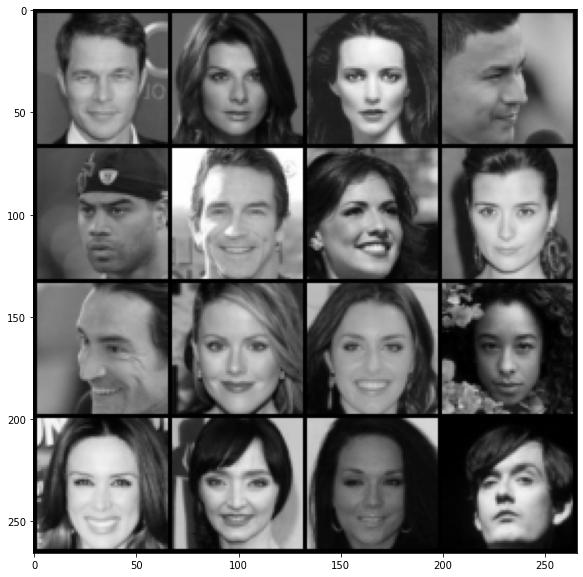

In [ ]:
#!L
samples = torch.stack([train_dataset[i][0] for i in range(32, 48)], dim=0)

plt.figure(figsize=(10, 10))
plt.imshow(make_grid(samples, nrow=4).permute(1, 2, 0))
plt.show()

### Autoencoder architecture

Let's design autoencoder as a single lasagne network, going from input image through bottleneck into the reconstructed image.

<img src="http://nghiaho.com/wp-content/uploads/2012/12/autoencoder_network1.png" width=640px>



## First step: PCA

Principial Component Analysis is a popular dimensionality reduction method. 

Under the hood, PCA attempts to decompose object-feature matrix $X$ into two smaller matrices: $W$ and $\hat W$ minimizing _mean squared error_:

$$\|(X W) \hat{W} - X\|^2_2 \to_{W, \hat{W}} \min$$
- $X \in \mathbb{R}^{n \times m}$ - object matrix (**centered**);
- $W \in \mathbb{R}^{m \times d}$ - matrix of direct transformation;
- $\hat{W} \in \mathbb{R}^{d \times m}$ - matrix of reverse transformation;
- $n$ samples, $m$ original dimensions and $d$ target dimensions;

In geometric terms, we want to find d axes along which most of variance occurs. The "natural" axes, if you wish.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/9/90/PCA_fish.png/256px-PCA_fish.png)


PCA can also be seen as a special case of an autoencoder.

* __Encoder__: X -> Dense(d units) -> code
* __Decoder__: code -> Dense(m units) -> X

Where Dense is a fully-connected layer with linear activaton:   $f(X) = W \cdot X + \vec b $


Note: the bias term in those layers is responsible for "centering" the matrix i.e. substracting mean.

In [6]:
#!L
class PCAAutoEncoder(nn.Module):
    """
    Here we define a simple linear autoencoder as described above.
    We also flatten and un-flatten data to be compatible with image shapes
    """
    
    def __init__(self, code_size=32, image_size = (1, 64, 64)):
        super(PCAAutoEncoder, self).__init__()
        
        flattened_size = int(np.prod(image_size))
        self.enc = torch.nn.Sequential(nn.Flatten(), torch.nn.Linear(flattened_size, code_size))
        self.dec = torch.nn.Sequential(torch.nn.Linear(code_size, flattened_size), nn.Unflatten(1, image_size))
    
    def batch_loss(self, batch):
        reconstruction = self.dec(self.enc((batch)))
        return torch.mean((batch - reconstruction) ** 2)

### Train the model

As usual, we iterate minibatches of data and call train_step, then evaluate loss on validation data.

In [ ]:
test_size = 19867

In [ ]:
#!L
def train(model, dataset, num_epoch=32, savename=None):
    model.to(device)
    optimizer = optim.Adamax(model.parameters(), lr=0.002)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    
    for epoch in range(num_epoch):
        losses = []
        
        for i, (batch, _) in enumerate(dataloader):
            optimizer.zero_grad()
            loss = model.batch_loss(batch.to(device))
            loss.backward()
            losses.append(loss.detach().cpu().numpy())
            optimizer.step()

        model_save_name = savename
        path = f"/content/{model_save_name}" 
        torch.save(aenc.state_dict(), path)
        
        print(f"#{epoch + 1}, Train loss: {np.mean(losses)}")

In [ ]:
#!L

test_size = 19867

from IPython.display import clear_output

def train_display(model, dataset, num_epoch=32, savename=None):
    model.to(device)
    optimizer = optim.Adamax(model.parameters(), lr=0.002)
    dataloader_train = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    dataloader_test = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

    reconstruction_mse = []
    epoch_losses = []
    for epoch in range(num_epoch):
        model.train()
        losses = []
        
        for batch, _ in dataloader_train:
            optimizer.zero_grad()
            loss = model.batch_loss(batch.to(device))
            loss.backward()
            losses.append(loss.detach().cpu().numpy())
            optimizer.step()


        scores = []
        model.eval()
        for batch in dataloader_test:
            scores.append(BATCH_SIZE * model.batch_loss(batch[0].to(device)).data.cpu().numpy())
        reconstruction_mse.append(np.divide(np.sum(scores), test_size))

        epoch_losses.append(np.mean(losses))

        clear_output()
        plt.plot(np.arange(epoch + 1), reconstruction_mse, label='test')
        plt.plot(np.arange(epoch + 1), epoch_losses, label='train')
        plt.legend()
        plt.show()



        model_save_name = savename
        path = f"/content/{model_save_name}{epoch}" 
        torch.save(model.state_dict(), path)
        
        print(f"#{epoch + 1}, Train loss: {epoch_losses[-1]}")

In [7]:
#!L
def visualize(img, model):
    """Draws original, encoded and decoded images"""
    code = model.enc(img[None].to(device))
    reco = model.dec(code)

    plt.subplot(1, 3, 1)
    plt.title("Original")
    plt.imshow(img.cpu().numpy().transpose([1, 2, 0]).clip(0, 1).squeeze())

    plt.subplot(1, 3, 2)
    plt.title("Code")
    plt.imshow(code.cpu().detach().numpy().reshape([code.shape[-1] // 2, -1]))

    plt.subplot(1, 3, 3)
    plt.title("Reconstructed")
    plt.imshow(reco[0].cpu().detach().numpy().transpose([1, 2, 0]).clip(0, 1).squeeze())

    if img.squeeze().dim() == 2:
        plt.gray()
    
    plt.show()


In [ ]:
#!L
aenc = PCAAutoEncoder()
train(aenc, train_dataset, 40, 'aenc.pt')

#1, Train loss: 0.03653506189584732
#2, Train loss: 0.011847435496747494
#3, Train loss: 0.010230027139186859
#4, Train loss: 0.010104136541485786
#5, Train loss: 0.010048199445009232
#6, Train loss: 0.010050331242382526
#7, Train loss: 0.010027100332081318
#8, Train loss: 0.010014953091740608
#9, Train loss: 0.010020251385867596
#10, Train loss: 0.010016495361924171
#11, Train loss: 0.01000930368900299
#12, Train loss: 0.010006197728216648
#13, Train loss: 0.010003546252846718
#14, Train loss: 0.010005099698901176
#15, Train loss: 0.00999999325722456
#16, Train loss: 0.010000219568610191
#17, Train loss: 0.01000220701098442
#18, Train loss: 0.00999836903065443
#19, Train loss: 0.009998115710914135
#20, Train loss: 0.010000107809901237
#21, Train loss: 0.009994196705520153
#22, Train loss: 0.009995155036449432
#23, Train loss: 0.009997939690947533
#24, Train loss: 0.010000286623835564
#25, Train loss: 0.009997978806495667
#26, Train loss: 0.00999511033296585
#27, Train loss: 0.00999735

In [ ]:
model_save_name = 'aenc.pt'
path = f"/content/{model_save_name}" 
torch.save(aenc.state_dict(), path)

In [ ]:
aenc_clone = PCAAutoEncoder()
aenc_clone.load_state_dict(aenc.state_dict())

<All keys matched successfully>

In [ ]:
train(aenc_clone, train_dataset, 13, savename='aenc.pt')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


#1, Train loss: 0.010437500663101673
#2, Train loss: 0.009992621839046478
#3, Train loss: 0.009992426261305809
#4, Train loss: 0.009998293593525887
#5, Train loss: 0.00999046303331852
#6, Train loss: 0.00999873410910368
#7, Train loss: 0.009987741708755493
#8, Train loss: 0.009990181773900986
#9, Train loss: 0.00999484397470951
#10, Train loss: 0.00999718252569437
#11, Train loss: 0.009991386905312538
#12, Train loss: 0.009992990642786026
#13, Train loss: 0.009990781545639038


In [ ]:
#!L
dataloader_test = DataLoader(validation_dataset, batch_size=BATCH_SIZE)
scores = []

for i, (batch, _) in enumerate(dataloader_test):
    scores.append(aenc.batch_loss(batch.to(device)).data.cpu().numpy())

print(np.mean(scores))

0.0099153565


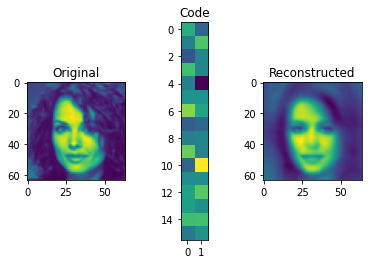

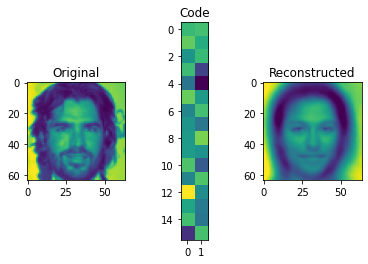

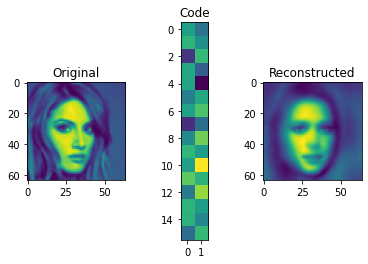

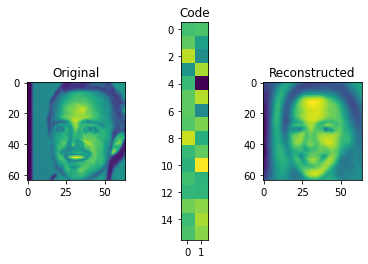

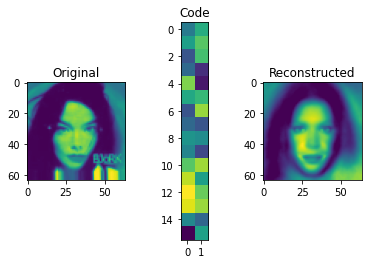

In [ ]:
#!L
for i in range(5):
    img = validation_dataset[i][0]
    visualize(img, aenc)


### Going deeper

PCA is neat but surely we can do better. This time we want to build a deep autoencoder by... stacking more layers.

In particular, our encoder and decoder should be at least 3 layers deep each, we can also use nonlinearity.

In [ ]:
#!L
class DeepPCAAutoEncoder(nn.Module):
    def __init__(self, code_size=32, image_size = (1, 64, 64)):
        super(DeepPCAAutoEncoder, self).__init__()
        
        self.enc = torch.nn.Sequential(                                                                                         # 64
                                        torch.nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1, stride=3),    # 22
                                        nn.BatchNorm2d(64),
                                        torch.nn.ReLU(),
                                        torch.nn.Conv2d(in_channels=64, out_channels=32, kernel_size=5, padding=2, stride=3),   # 8
                                        nn.BatchNorm2d(32),
                                        torch.nn.ReLU(),
                                        torch.nn.Conv2d(in_channels=32, out_channels=2, kernel_size=3, padding=2, stride=3),    # 4

                                        nn.BatchNorm2d(2),
                                        torch.nn.ReLU(),
                                        torch.nn.Flatten(),
                                        nn.Linear(2 * 4 * 4, code_size)
                                        )
        self.dec = torch.nn.Sequential(nn.Linear(code_size, 2 * 4 * 4),
                                       torch.nn.Unflatten(1, (2, 4, 4)),                                                                                      # 4
                                       torch.nn.ConvTranspose2d(in_channels=2, out_channels=32, kernel_size=3, padding=2, stride=3),                    # 8
                                       torch.nn.BatchNorm2d(32),
                                       torch.nn.ReLU(),
                                       torch.nn.ConvTranspose2d(in_channels=32, out_channels=64, kernel_size=5, padding=2, stride=3),                   # 22
                                       torch.nn.BatchNorm2d(64),
                                       torch.nn.ReLU(),
                                       torch.nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=3, padding=1, stride=3),                    # 64 
                                       )
    
    def batch_loss(self, batch):
        reconstruction = self.dec(self.enc(batch))
        return torch.mean((batch - reconstruction)**2)

In [ ]:
#!L
%%time
aenc_deep = DeepPCAAutoEncoder()
train(aenc_deep, train_dataset, 50, 'aenc.pt')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


#1, Train loss: 0.02471691556274891
#2, Train loss: 0.01822614297270775
#3, Train loss: 0.017250295728445053
#4, Train loss: 0.016923952847719193
#5, Train loss: 0.01672733575105667
#6, Train loss: 0.01658673584461212
#7, Train loss: 0.01642836630344391
#8, Train loss: 0.015938133001327515
#9, Train loss: 0.015734359622001648
#10, Train loss: 0.015614621341228485
#11, Train loss: 0.015525802969932556
#12, Train loss: 0.01543097198009491
#13, Train loss: 0.015379935503005981
#14, Train loss: 0.015350383706390858
#15, Train loss: 0.015313303098082542
#16, Train loss: 0.015274327248334885
#17, Train loss: 0.015249964781105518
#18, Train loss: 0.015237446874380112
#19, Train loss: 0.015217918902635574
#20, Train loss: 0.015191739425063133
#21, Train loss: 0.01516161859035492
#22, Train loss: 0.01514766737818718
#23, Train loss: 0.015128804370760918
#24, Train loss: 0.015115506947040558
#25, Train loss: 0.015102009288966656
#26, Train loss: 0.015089532360434532
#27, Train loss: 0.0150703340

In [ ]:
img_shape = torch.Size([1, 64, 64])

In [ ]:
#!L
def get_dim(layer): return np.prod(layer.output_shape[1:])


for code_size in [1, 8, 32, 128, 512, 1024]:
    help_tensor = next(iter(DataLoader(train_dataset, batch_size=BATCH_SIZE)))
    model = DeepPCAAutoEncoder(code_size).to(device)
    encoder_out = model.enc(help_tensor[0].to(device))
    decoder_out = model.dec(encoder_out)

    print("Testing code size %i" % code_size)

    assert encoder_out.shape[1:] == torch.Size(
        [code_size]), "encoder must output a code of required size"
    assert decoder_out.shape[1:] == img_shape, "decoder must output an image of valid shape"
    assert len(list(model.dec.children())) >= 6,  "decoder must contain at least 3 dense layers"

print("All tests passed!")

Testing code size 1
Testing code size 8
Testing code size 32
Testing code size 128
Testing code size 512
Testing code size 1024
All tests passed!


Final MSE: 0.012370788


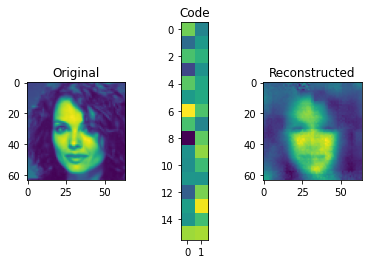

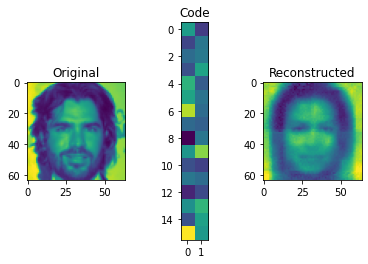

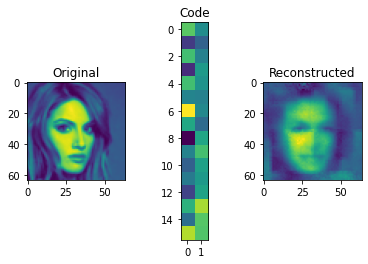

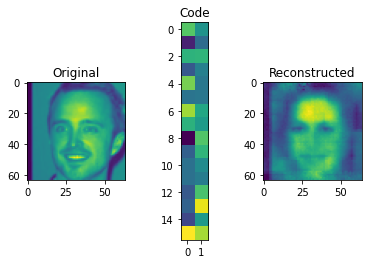

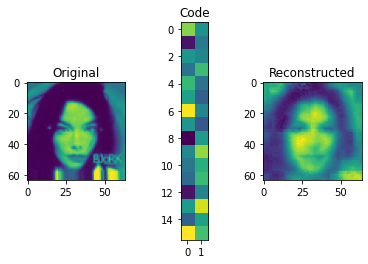

In [ ]:
#!L
dataloader_test = DataLoader(validation_dataset, batch_size=BATCH_SIZE)
scores = []
for i, (batch) in enumerate(dataloader_test):
    scores.append(aenc_deep.batch_loss(batch[0].to(device)).data.cpu().numpy())
    encoder_out = aenc_deep.enc(batch[0].to(device))

reconstruction_mse = np.mean(scores)

assert len(encoder_out.shape) == 2 and encoder_out.shape[1] == 32, \
    "Make sure encoder has code_size units"

print("Final MSE:", reconstruction_mse)
for i in range(5):
    img = validation_dataset[i][0]
    visualize(img, aenc_deep)

Видим, что качество модели оказалось не очень высоким. Попробуем увеличить количество входных нейронов в кодирующем FC-слое и добавить ещё свертку у входа и выхода модели

In [ ]:
#!L
class DeepPCAAutoEncoder(nn.Module):
    def __init__(self, code_size=32, image_size = (1, 64, 64)):
        super(DeepPCAAutoEncoder, self).__init__()
        
        self.enc = torch.nn.Sequential(
                                        torch.nn.Conv2d(in_channels=1, out_channels=128, kernel_size=3, padding=1, stride=1),   # 64
                                        nn.BatchNorm2d(128),
                                        torch.nn.ReLU(),
                                        torch.nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1, stride=3),    # 22
                                        nn.BatchNorm2d(64),
                                        torch.nn.ReLU(),
                                        torch.nn.Conv2d(in_channels=64, out_channels=32, kernel_size=5, padding=2, stride=3),   # 8
                                        nn.BatchNorm2d(32),
                                        torch.nn.ReLU(),
                                        torch.nn.Conv2d(in_channels=32, out_channels=2, kernel_size=3, padding=2, stride=3),    # 4
                                        nn.BatchNorm2d(2),
                                        torch.nn.ReLU(),
                                        torch.nn.Flatten(),
                                        nn.Linear(2 * 4 * 4, code_size)
                                        )
        self.dec = torch.nn.Sequential(nn.Linear(code_size, 2 * 4 * 4),
                                       torch.nn.Unflatten(1, (2, 4, 4)),                                                                                      # 4
                                       torch.nn.ConvTranspose2d(in_channels=2, out_channels=32, kernel_size=3, padding=2, stride=3),                    # 8
                                       torch.nn.BatchNorm2d(32),
                                       torch.nn.ReLU(),
                                       torch.nn.ConvTranspose2d(in_channels=32, out_channels=64, kernel_size=5, padding=2, stride=3),                   # 22
                                       torch.nn.BatchNorm2d(64),
                                       torch.nn.ReLU(),
                                       torch.nn.ConvTranspose2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=3),                    # 64 
                                       nn.BatchNorm2d(64),
                                       torch.nn.ReLU(),
                                       torch.nn.ConvTranspose2d(in_channels=128, out_channels=1, kernel_size=3, padding=1, stride=1), 
                                       nn.UpsamplingBilinear2d(64)
                                       )
    
    def batch_loss(self, batch):
        reconstruction = self.dec(self.enc(batch))
        return torch.mean((batch - reconstruction)**2)

    def forward(self, input):
        return self.dec(self.enc(imput))

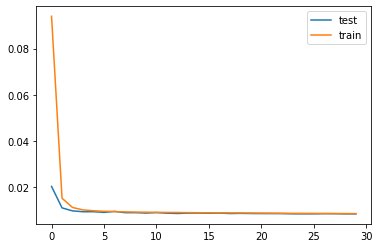

#30, Train loss: 0.008611448109149933


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
#!L
%%time
aenc_deep = DeepPCAAutoEncoder()
train_display(aenc_deep, train_dataset, 50, 'aenc.pt')

Модель к 30й эпохе уже показывает результаты лучше, чем предыдущая (примерно в 2 раза - было 0.015), но из-за лимита на использование GPU в колабе закончить обучение не вышло :(

## Denoising AutoEncoder

Let's now make our model into a denoising autoencoder.

There are many strategies to apply noise. We'll implement two popular one: adding gaussian noise and using dropout.

In [8]:
def apply_gaussian_noise(X,sigma=0.1):
    """
    adds noise from normal distribution with standard deviation sigma
    :param X: image tensor of shape [batch,height,width,3]
    """
    noise = sigma * torch.zeros(X.shape).data.normal_()
    return X + noise.cuda()

def apply_gaussian_noise_numpy(X,sigma=0.1):
    """
    adds noise from normal distribution with standard deviation sigma
    :param X: image tensor of shape [batch,height,width,3]
    """
    noise = sigma * torch.zeros(X.shape).data.normal_().numpy()
    return X + noise

**noise tests**

In [ ]:
#!L
X = torch.stack([train_dataset[i][0] for i in range(100)], dim=0)
theoretical_std = (X.std() ** 2 + 0.5 ** 2) ** .5
our_std = apply_gaussian_noise(X, sigma=0.5).std()

assert abs(theoretical_std - our_std) < 0.01, \
    "Standard deviation does not match it's required value. Make sure you use sigma as std."
assert abs(apply_gaussian_noise(X, sigma=0.5).mean() - X.mean()) < 0.01, \
    "Mean has changed. Please add zero-mean noise"

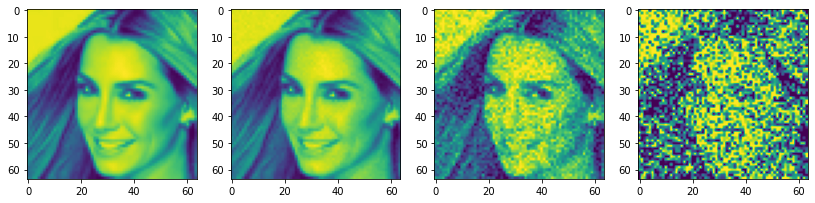

In [ ]:
#!L
plt.figure(figsize=(14, 4))
plt.subplot(1, 4, 1)
plt.imshow(np.squeeze(X[0].permute([1, 2, 0])))
plt.subplot(1, 4, 2)
plt.imshow(np.squeeze(apply_gaussian_noise(X[:1], sigma=0.01)[0].cpu().data.permute([1, 2, 0]).clip(0, 1)))
plt.subplot(1, 4, 3)
plt.imshow(np.squeeze(apply_gaussian_noise(X[:1], sigma=0.1)[0].cpu().data.permute([1, 2, 0]).clip(0, 1)))
plt.subplot(1, 4, 4)
plt.imshow(np.squeeze(apply_gaussian_noise(X[:1], sigma=0.5)[0].cpu().data.permute([1, 2, 0]).clip(0, 1)))

In [9]:
#!L
class pca_autoencoder(nn.Module):
    """
    Here we define a simple linear autoencoder as described above.
    We also flatten and un-flatten data to be compatible with image shapes
    """
    
    def __init__(self, code_size=32):
        super(pca_autoencoder, self).__init__()
        
        self.enc = torch.nn.Sequential(nn.Flatten(), torch.nn.Linear(64*64, code_size))
        self.dec = torch.nn.Sequential(torch.nn.Linear(code_size, 64*64), nn.Unflatten(1, (1,64,64)))
    
    def batch_loss(self, batch, apply_noise=False):
        if apply_noise:
            processed_batch = apply_gaussian_noise(batch)
        else:
            processed_batch = batch

        reconstruction = self.dec(self.enc((batch)))
        return torch.mean((batch - reconstruction) ** 2)

In [ ]:
#!L
def train_noise(model, dataset, num_epoch=50, savename=None):
    model.to(device)
    optimizer = optim.Adamax(model.parameters(), lr=0.002)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    
    for epoch in range(num_epoch):
        losses = []
        
        for i, (batch, _) in enumerate(dataloader):
            optimizer.zero_grad()
            loss = model.batch_loss(batch.to(device), apply_noise=True)
            (loss).backward()
            losses.append(loss.detach().cpu().numpy())
            optimizer.step()

        model_save_name = savename
        path = f"/content/{model_save_name}" 
        torch.save(model.state_dict(), path)
        
        print(f"#{epoch + 1}, Train loss: {np.mean(losses)}")

In [ ]:
#!L
%%time
aenc = pca_autoencoder()
train_noise(aenc, train_dataset, 50, savename='aenc.pt')

#1, Train loss: 0.03879033774137497
#2, Train loss: 0.011770350858569145
#3, Train loss: 0.010186226107180119
#4, Train loss: 0.010082815773785114
#5, Train loss: 0.01005250122398138
#6, Train loss: 0.010042991489171982
#7, Train loss: 0.010032224468886852
#8, Train loss: 0.01002904400229454
#9, Train loss: 0.01001498382538557
#10, Train loss: 0.010016742162406445
#11, Train loss: 0.01001261081546545
#12, Train loss: 0.010013077408075333
#13, Train loss: 0.010004129260778427
#14, Train loss: 0.010016166605055332
#15, Train loss: 0.010006309486925602
#16, Train loss: 0.010002996772527695
#17, Train loss: 0.010002411901950836
#18, Train loss: 0.010005813091993332
#19, Train loss: 0.010002491995692253
#20, Train loss: 0.009999890811741352
#21, Train loss: 0.00999950710684061
#22, Train loss: 0.009995320811867714
#23, Train loss: 0.009996251203119755
#24, Train loss: 0.009992636740207672
#25, Train loss: 0.009994597174227238
#26, Train loss: 0.009996984153985977
#27, Train loss: 0.00999637

**Let's evaluate!!!**

Final MSE: 0.00990028


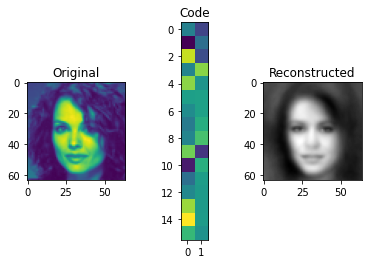

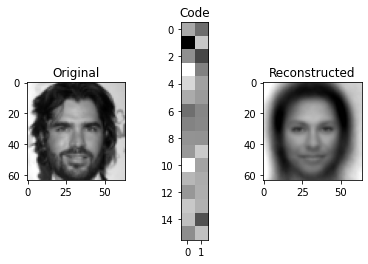

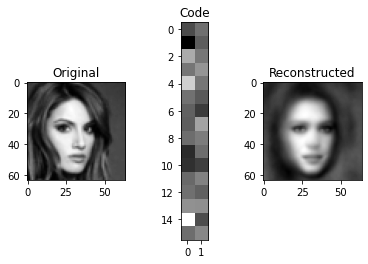

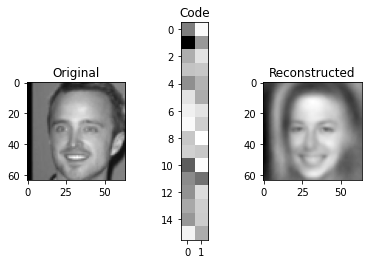

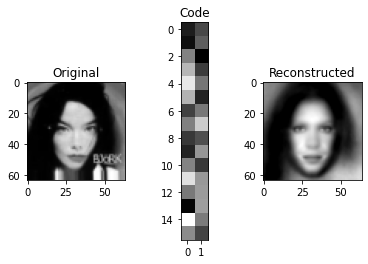

In [13]:
#!L
dataloader_test = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)
scores = []

for i, (batch) in enumerate(dataloader_test):
    scores.append(aenc.batch_loss(batch[0].to(device)).data.cpu().numpy())
    encoder_out = aenc.enc(batch[0].to(device))

reconstruction_mse = np.mean(scores)

print("Final MSE:", reconstruction_mse)
for i in range(5):
    img = validation_dataset[i][0]
    visualize(img, aenc)

### Image retrieval with autoencoders

So we've just trained a network that converts image into itself imperfectly. This task is not that useful in and of itself, but it has a number of awesome side-effects. Let's see it in action.

First thing we can do is image retrieval aka image search. We we give it an image and find similar images in latent space. 

To speed up retrieval process, we shall use **[hnswlib](https://github.com/nmslib/hnswlib)** on top of encoded vectors. **hnswlib** is fast approximate nearest neighbor search. If you want to learn more about fast kNN, take a look at https://github.com/erikbern/ann-benchmarks.

In [14]:
aenc=PCAAutoEncoder().to(device)
aenc.load_state_dict(torch.load('aenc.pt'))

<All keys matched successfully>

In [ ]:
%pip install hnswlib

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hnswlib: filename=hnswlib-0.5.1-cp37-cp37m-linux_x86_64.whl size=1303030 sha256=b8ca01e9ec9f0c086275570bb3206f6083017482ac75068556a859a0a5254512
  Stored in directory: /root/.cache/pip/wheels/46/7b/98/44c3a8a284506a54993f0b321e4a32a0c9e69215bbb72feff5
Successfully built hnswlib


In [16]:
X_train = list(train_dataset)

In [17]:
X, _ = zip(*X_train)

In [ ]:
X[0]

tensor([[[0.9353, 0.9381, 0.9381,  ..., 0.4111, 0.3353, 0.5407],
         [0.9402, 0.9406, 0.9406,  ..., 0.5236, 0.3977, 0.3420],
         [0.9441, 0.9450, 0.9450,  ..., 0.5232, 0.5336, 0.4111],
         ...,
         [0.3346, 0.3877, 0.4147,  ..., 0.1693, 0.1563, 0.3764],
         [0.3349, 0.3875, 0.4663,  ..., 0.2423, 0.1412, 0.3372],
         [0.4224, 0.4106, 0.5340,  ..., 0.2660, 0.1515, 0.2292]]])

In [18]:
X = torch.stack(X)

In [ ]:
#!L
# encodes batch of images into a codes

codes =  aenc.enc(X.to(device))

In [ ]:
#!L
assert codes.shape[0] == len(train_dataset)

In [ ]:
#!L
import hnswlib

p = hnswlib.Index(space='l2', dim=codes.shape[1])

p.init_index(max_elements = codes.shape[0], ef_construction = 200, M = 16)
p.add_items(codes.cpu().detach().numpy(), np.arange(codes.shape[0]))
p.set_ef(50) # ef should always be > k


In [ ]:
#!L
def get_similar(image, n_neighbors=5):
    assert len(image.shape) == 3, "image must be [batch,height,width,3]"

    code =  aenc.enc(image).cpu().detach().numpy()

    idx, distances = p.knn_query(code, n_neighbors)

    return distances.squeeze(0), X[idx.squeeze(0).astype(np.int64)]

In [ ]:
#!L
def show_similar(image):

    distances, neighbors = get_similar(image, n_neighbors=11)

    plt.figure(figsize=[8, 6])
    plt.subplot(3, 4, 1)
    plt.imshow(image.cpu().numpy().squeeze(0))
    plt.title("Original image")

    for i in range(11):
        plt.subplot(3, 4, i+2)
        plt.imshow(neighbors[i].cpu().numpy().squeeze(0))
        plt.title("Dist=%.3f" % distances[i])
    plt.show()

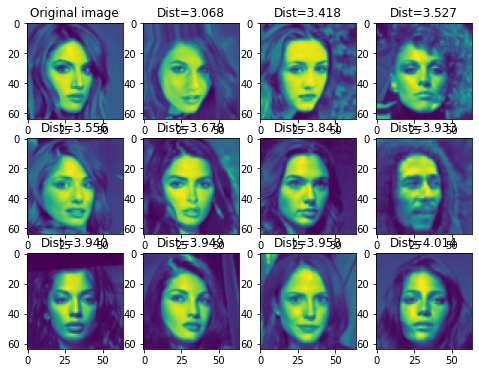

In [ ]:
#!L
show_similar(validation_dataset[2][0].to(device))

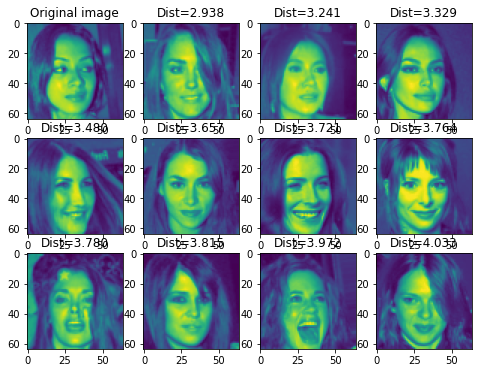

In [ ]:
#!L
show_similar(validation_dataset[500][0].to(device))

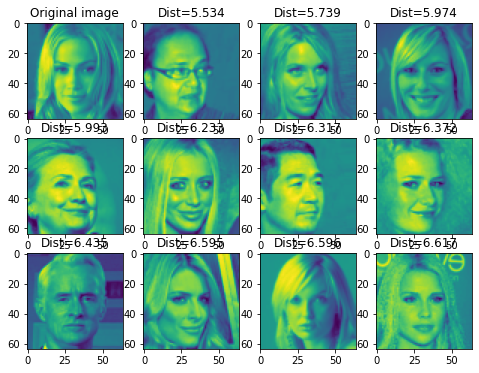

In [ ]:
#!L
show_similar(validation_dataset[66][0].to(device))

## Cheap image morphing


Here we will take two full-sized objects, code it and obtain intermediate object by decoding an intermixture code.

$Code_{mixt} = a1\cdot code1 + a2\cdot code2$

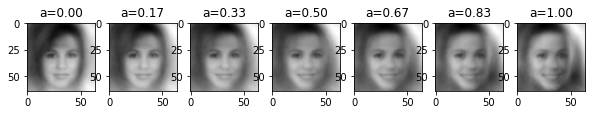

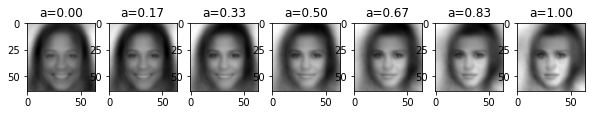

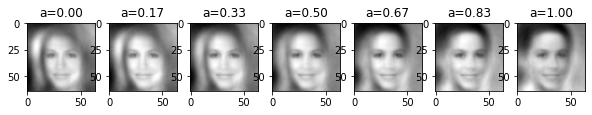

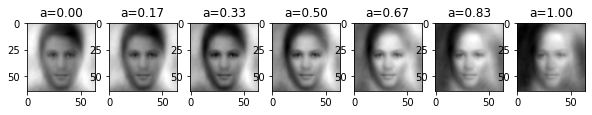

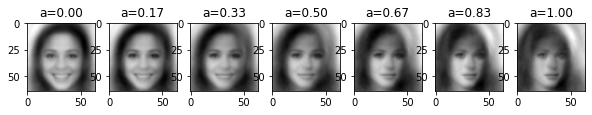

In [33]:
#!L
for _ in range(5):
    image1, image2 =  X[np.random.randint(len(X))], X[np.random.randint(len(X))]

    code1, code2 = aenc.enc(image1.to(device)), aenc.enc(image2.to(device))

    plt.figure(figsize=[10, 4])
    for i, a in enumerate(np.linspace(0, 1, num=7)):

        output_code = code1 * a + code2 * (1. - a)

        output_image = aenc.dec(output_code)[0]
        plt.subplot(1, 7, i+1)
        plt.imshow(output_image.cpu().detach().numpy().squeeze(0))
        plt.title("a=%.2f" % a)

    plt.show()